In [1]:
import numpy as np  # pacote para fazer computaçao cientifica em python
import random # para trabalhar com números aleatórios e implementar o SGD
from sklearn.datasets import fetch_mldata # para importar a base de dados do MNIST
import matplotlib.pyplot as plt # pra criar gráficos, etc
import pylab 
import random # para trabalhar com números aleatórios
import pandas as pd #para criar o dataframe
import time #para medir o tempo
import pickle #para guardar os pesos e os bias no HDD
%matplotlib inline

In [2]:
mnist = fetch_mldata('MNIST original')

In [3]:
def vetorizar_output(n):
    """Converte um dígito em um vetor de 10 elementos onde todos sao 
    0 menos o elemento n que é 1"""
    vetor = np.zeros(shape=(10, 1))
    vetor[n] = 1
    return(vetor)

In [4]:
inputs = [np.reshape(x, (784, 1)) for x in mnist.data]
outputs_vetor = [vetorizar_output(int(output)) for output in mnist.target]
outputs_numero = [int(output) for output in mnist.target]
training_data = list(zip(inputs, outputs_vetor, outputs_numero))

"""Manipulaçao dos dados da BD. training_data é uma lista que contém uma lista de tuplas
que contém cada uma um vetor de entrada, um vetor com a saida desejada, e um inteiro
com a saida desejada."""

dados_treinamento = training_data[:60000] # conjunto de treinamento com 60k dados
dados_teste = training_data[60000:] # conjunto de teste com 10k dados

In [5]:
def debuxar_numero(vetor_input):
    matriz = np.reshape(vetor_input, (28, 28))
    
    plt.axis('off')
    image = plt.imshow(matriz, cmap=plt.cm.gray_r, interpolation='none')
    return image

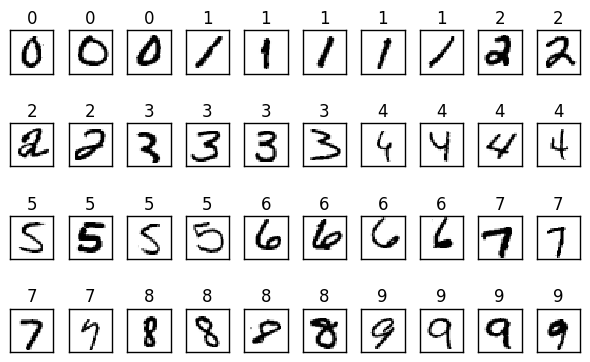

In [7]:
f = pylab.figure()


for i in range(1, 41, 1):
    indice = int(60000/41*i + 333)
    f.add_subplot(4, 10, i)
    number = training_data[indice][0]
    image = debuxar_numero(number)
    plt.axis('on')
    image.axes.get_xaxis().set_visible(False)
    image.axes.get_yaxis().set_visible(False)
    plt.title("{}".format(training_data[indice][2]))

f.tight_layout()

#cria matriz de imagens com amostras do conjunto de treinamento e a saida desejada

In [8]:
class Rede(object) :
    
    def __init__(self, nos): # construtor de clase receve lista com nós por camada
        self.num_camadas = len(nos) # o número de camadas é o tamanho da lista de nós
        self.nos = nos # lista de nós que ha em cada camada, incluindo a de entrada
        self.biases = [np.random.randn(y, 1) for y in nos[1:]]
            #cria uma lista de vetores de bias, inicializa com valores da distribuiçao normal padrao
        self.pesos = [np.random.randn(y, x) for x, y in zip(nos[:-1], nos[1:])]
             #cria uma lista de matrizes de pesos, inicializa com valores da distribuiçao normal padrao
        self.delta_b = [np.zeros(b.shape) for b in self.biases]
            #lista com as variaçoes anteriores dos deltas, para utilizar momento
        self.delta_w = [np.zeros(w.shape) for w in self.pesos]    
            #lista com as variaçoes anteriores dos pesos, para utilizar momento
            
            
    def treina_mini_batch(self, mini_batch, eta, alpha):
        """Update the network's pesos and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.pesos]
        for x in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backpropagation(x[0], x[1])
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        delta_w = [(eta/len(mini_batch))*nw for nw in nabla_w] #cambios nos pesos neste mini batch sem momento
        delta_b = [(eta/len(mini_batch))*nb for nb in nabla_b] #cambios nos bias neste mini batch sem momento
        self.pesos = [w+alpha*dw_anterior-dw
                        for w, dw, dw_anterior in zip(self.pesos, delta_w, self.delta_w)]
        self.biases = [b+alpha*db_anterior-db
                       for b, db, db_anterior in zip(self.biases, delta_b, self.delta_b)]
        self.delta_w = delta_w #guarda a variaçoe dos pesos neste paso para utilizar momento no próximo
        self.delta_b = delta_b #guarda a variaçoe dos bias neste paso para utilizar momento no próximo
        
        
    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.pesos):
            a = sigmoide(np.dot(w, a)+b)
        return a
    
    def SGD(self, dados_treinamento_SGD, epocas, tamanho_mini_batch, eta, alpha,
            dados_teste_SGD):
        """Treina a rede usando gradiente descendente estocástico, com mini batches.
        Converge muito mais rápido se usamos como batch o conjunto inteiro de treinamento.
        Vai atualizando os pesos e os bias depois de calcular o gradiente para cada mini batch.
        """
        n_test = len(dados_teste_SGD)
        n = len(dados_treinamento_SGD)
        df_aprendizado = pd.DataFrame(index=range(epocas))
        start = time.time()
        df_aprendizado = pd.DataFrame(index=np.arange(epocas), data=np.zeros((epocas, 4)), 
                             columns=["Época",
                                      "Percentagem de acerto", 
                                      "Erro treinamento",
                                      "Tempo desde o começo"])
        print("Época \tPercentagem de acerto \tErro treinamento \tTempo desde o começo")
        for epoca in range(epocas):
            random.shuffle(dados_treinamento_SGD)
            mini_batches = [
                dados_treinamento_SGD[k:k+tamanho_mini_batch]
                for k in range(0, n, tamanho_mini_batch)]
            for mini_batch in mini_batches:
                self.treina_mini_batch(mini_batch, eta, alpha)
#             print( "Epoch {0}: {1} / {2}".format(j, self.avalia(dados_teste), n_test))
            percentagem_acerto = self.avalia(dados_teste_SGD) / n_test * 100
            erro_treinamento = self.custo_medio(dados_treinamento_SGD)
            tempo = time.time() - start
            dados_epoca = [epoca + 1, percentagem_acerto, erro_treinamento, tempo]
            df_aprendizado.loc[epoca] = dados_epoca
            
            print( "{0}\t{1:.2f}\t\t\t{2:.5f}\t\t\t{3:.3f}".
                  format(epoca, 
                         percentagem_acerto,
                         erro_treinamento,
                         tempo))
        df_aprendizado["Época"] = df_aprendizado["Época"].astype(int)
        
        return df_aprendizado
    
    def SGD_rapido(self, dados_treinamento_SGD, epocas, tamanho_mini_batch, eta, alpha,
            dados_teste_SGD):
        """Treina a rede usando gradiente descendente estocástico, com mini batches.
        Converge muito mais rápido se usamos como batch o conjunto inteiro de treinamento.
        Vai atualizando os pesos e os bias depois de calcular o gradiente para cada mini batch.
        """
        n_test = len(dados_teste_SGD)
        n = len(dados_treinamento_SGD)
        df_aprendizado = pd.DataFrame(index=range(epocas))
        for epoca in range(epocas):
            random.shuffle(dados_treinamento_SGD)
            mini_batches = [
                dados_treinamento_SGD[k:k+tamanho_mini_batch]
                for k in range(0, n, tamanho_mini_batch)]
            for mini_batch in mini_batches:
                self.treina_mini_batch(mini_batch, eta, alpha)
            percentagem_acerto = self.avalia(dados_teste_SGD) / n_test * 100
#             erro_teste = self.custo_medio(dados_teste_SGD)
            print( "Epoca {0}: Percentagem de acerto: {1:.2f}".format(epoca, percentagem_acerto))
    
            
    def custo_medio(self, dados):
        custos = []
        for x in dados:
            custo = (x[1] - self.feedforward(x[0]))
            custo = np.reshape(custo, len(custo))
            custo = custo.dot(custo)
            custos.append(custo)

        custos = np.array(custos)
        custo_medio = 0.5 * custos.mean()
        return custo_medio
            
            
    def backpropagation(self, x, y):
        """Retorna uma tupla de 2 listas com os gradientes do erro com respeto 
        aos bias e aos pesos de cada camada"""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.pesos]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.pesos):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoide(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * sigmoide_prima(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        for l in range(2, self.num_camadas):
            z = zs[-l]
            sp = sigmoide_prima(z)
            delta = np.dot(self.pesos[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)
    
    
    
    def avalia(self, dados_teste):
        tamanho_teste = len(dados_teste)
        sucessos = 0
        for caso_teste in dados_teste:
            if(np.argmax(self.feedforward(caso_teste[0])) == caso_teste[2]):
                sucessos += 1
        return sucessos

    def cost_derivative(self, saida, saida_desejada):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return (saida - saida_desejada)
    
    
def sigmoide(z):
    return 1 / (1 + np.exp(-z))

def sigmoide_prima(z):
    """Derivada da sigmoide"""
    return sigmoide(z)*(1-sigmoide(z))



In [11]:
rede = Rede([784, 40, 10])

In [ ]:
#teste com SGD e momento. Taxa de aprendizado 0.3, alpha 0.5, tamanho_mini_batch 10 
rede.SGD(dados_treinamento[0:60000:1], 40, 10, 0.3, 0.5, dados_teste[0:10000:1])

Época 	Percentagem de acerto 	Erro treinamento 	Tempo desde o começo


C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:159: RuntimeWarning: overflow encountered in exp


In [349]:
pesos_rede_xoel = rede.pesos
pickle.dump(pesos_rede_xoel, open("rede_Xoel.p", "wb"))
#para guardar os pesos sem ter que treinar a rede de novo

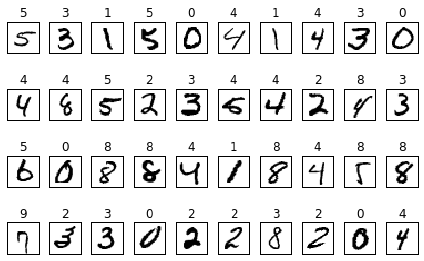

In [342]:
f = pylab.figure()


for i in range(1, 41, 1):
    indice = np.random.randint(0, 10000)
    f.add_subplot(4, 10, i)
    number = dados_teste[indice][0]
    image = debuxar_numero(number)
    plt.axis('on')
    image.axes.get_xaxis().set_visible(False)
    image.axes.get_yaxis().set_visible(False)
    plt.title("{}".format(np.argmax(rede.feedforward(dados_teste[indice][0]))))

f.tight_layout()